In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

os.environ['XILINX_VITIS'] = '/tools/Xilinx/Vitis/2024.2'
os.environ['PATH'] = '/tools/Xilinx/Vivado/2020.1/bin:' + os.environ['PATH']
os.environ['PATH'] = '/tools/Xilinx/Vitis_HLS/2024.2/bin:' + os.environ['PATH']

2025-04-09 14:03:01.023429: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-09 14:03:01.048436: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-09 14:03:01.158373: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-09 14:03:01.158391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-09 14:03:01.177239: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize the pixel values to [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

# Reshape to add channel dimension (28x28x1)
x_train = x_train.reshape((-1, 28, 28, 1))
x_test  = x_test.reshape((-1, 28, 28, 1))

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test, 10)

# Split off a validation set
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# Create tf.data.Dataset objects (optional but recommended for performance)
batch_size = 1024

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(batch_size)
val_data   = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(batch_size)
test_data  = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

# Optional: set number of epochs
n_epochs = 10

train_size = len(x_train) 

input_shape = (28, 28, 1)
n_classes = 10

In [3]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

from tensorflow.keras.models import Model

filters_per_conv_layer = [16, 24]
neurons_per_dense_layer = [42]

x = x_in = Input(input_shape)

for i, f in enumerate(filters_per_conv_layer):
    print(('Adding convolutional block {} with N={} filters').format(i, f))
    x = Conv2D(
        int(f),
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        use_bias=False,
        name='conv_{}'.format(i),
    )(x)
    x = BatchNormalization(name='bn_conv_{}'.format(i))(x)
    x = Activation('relu', name='conv_act_%i' % i)(x)
    x = MaxPooling2D(pool_size=(2, 2), name='pool_{}'.format(i))(x)
x = Flatten()(x)

for i, n in enumerate(neurons_per_dense_layer):
    print(('Adding dense block {} with N={} neurons').format(i, n))
    x = Dense(n, kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001), name='dense_%i' % i, use_bias=False)(x)
    x = BatchNormalization(name='bn_dense_{}'.format(i))(x)
    x = Activation('relu', name='dense_act_%i' % i)(x)
x = Dense(int(n_classes), name='output_dense')(x)
x_out = Activation('softmax', name='output_softmax')(x)

model = Model(inputs=[x_in], outputs=[x_out], name='keras_baseline')

model.summary()

Adding convolutional block 0 with N=16 filters
Adding convolutional block 1 with N=24 filters
Adding dense block 0 with N=42 neurons
Model: "keras_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv_0 (Conv2D)             (None, 26, 26, 16)        144       
                                                                 
 bn_conv_0 (BatchNormalizat  (None, 26, 26, 16)        64        
 ion)                                                            
                                                                 
 conv_act_0 (Activation)     (None, 26, 26, 16)        0         
                                                                 
 pool_0 (MaxPooling2D)       (None, 13, 13, 16)        0         
                                                   

In [4]:
for layer in model.layers:
    if layer.__class__.__name__ in ['Conv2D', 'Dense']:
        w = layer.get_weights()[0]
        layersize = np.prod(w.shape)
        print("{}: {}".format(layer.name, layersize))  # 0 = weights, 1 = biases
        if layersize > 4096:  # assuming that shape[0] is batch, i.e., 'None'
            print("Layer {} is too large ({}), are you sure you want to train?".format(layer.name, layersize))

conv_0: 144
conv_1: 3456
dense_0: 25200
Layer dense_0 is too large (25200), are you sure you want to train?
output_dense: 420


In [5]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks

NSTEPS = int(train_size * 0.9) // batch_size  # 90% train, 10% validation in 10-fold cross validation
print('Number of training steps per epoch is {}'.format(NSTEPS))


# Prune all convolutional and dense layers gradually from 0 to 50% sparsity every 2 epochs,
# ending by the 10th epoch
def pruneFunction(layer):
    pruning_params = {
        'pruning_schedule': sparsity.PolynomialDecay(
            initial_sparsity=0.0, final_sparsity=0.50, begin_step=NSTEPS * 2, end_step=NSTEPS * 10, frequency=NSTEPS
        )
    }
    if isinstance(layer, tf.keras.layers.Conv2D):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    if isinstance(layer, tf.keras.layers.Dense) and layer.name != 'output_dense':
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    return layer


model_pruned = tf.keras.models.clone_model(model, clone_function=pruneFunction)

Number of training steps per epoch is 47


In [6]:
import tensorflow as tf
print(tf.__version__)


2.15.1


In [7]:
models_path = 'models'

In [8]:
train = True  # True if you want to retrain, false if you want to load a previsously trained model

n_epochs = 30

save_path = os.path.join(models_path, 'pruned_cnn_model.h5')

if train:
    LOSS = tf.keras.losses.CategoricalCrossentropy()
    OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=3e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)

    model_pruned.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        pruning_callbacks.UpdatePruningStep(),
    ]

    start = time.time()
    model_pruned.fit(train_data, epochs=n_epochs, validation_data=val_data, callbacks=callbacks)
    end = time.time()

    print('It took {} minutes to train Keras model'.format((end - start) / 60.0))
    model_pruned.save(save_path)


else:
    from qkeras.utils import _add_supported_quantized_objects
    from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    model_pruned = tf.keras.models.load_model('pruned_cnn_model.h5', custom_objects=co)

Epoch 1/30
53/53 [==============================] - 2s 23ms/step - loss: 0.5694 - accuracy: 0.9021 - val_loss: 0.9116 - val_accuracy: 0.8503 - lr: 0.0030
Epoch 2/30
53/53 [==============================] - 1s 21ms/step - loss: 0.2081 - accuracy: 0.9779 - val_loss: 2.2404 - val_accuracy: 0.2517 - lr: 0.0030
Epoch 3/30
53/53 [==============================] - 1s 21ms/step - loss: 0.1510 - accuracy: 0.9855 - val_loss: 3.1326 - val_accuracy: 0.1788 - lr: 0.0030
Epoch 4/30
52/53 [============================>.] - ETA: 0s - loss: 0.1215 - accuracy: 0.9886
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
53/53 [==============================] - 1s 21ms/step - loss: 0.1215 - accuracy: 0.9886 - val_loss: 3.3194 - val_accuracy: 0.1690 - lr: 0.0030
Epoch 5/30
53/53 [==============================] - 1s 20ms/step - loss: 0.0986 - accuracy: 0.9916 - val_loss: 2.5539 - val_accuracy: 0.2585 - lr: 0.0015
Epoch 6/30
53/53 [==============================] - 1s 21ms/step - loss:

/home/theodoros/Documents/AI_ON_FPGA/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
from qkeras import QActivation
from qkeras import QDense, QConv2DBatchnorm

x = x_in = Input(shape=input_shape)

for i, f in enumerate(filters_per_conv_layer):
    print(('Adding fused QConv+BN block {} with N={} filters').format(i, f))
    x = QConv2DBatchnorm(
        int(f),
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_quantizer="quantized_bits(6,0,alpha=1)",
        bias_quantizer="quantized_bits(6,0,alpha=1)",
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        use_bias=True,
        name='fused_convbn_{}'.format(i),
    )(x)
    x = QActivation('quantized_relu(6)', name='conv_act_%i' % i)(x)
    x = MaxPooling2D(pool_size=(2, 2), name='pool_{}'.format(i))(x)
x = Flatten()(x)

for i, n in enumerate(neurons_per_dense_layer):
    print(('Adding QDense block {} with N={} neurons').format(i, n))
    x = QDense(
        n,
        kernel_quantizer="quantized_bits(6,0,alpha=1)",
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        name='dense_%i' % i,
        use_bias=False,
    )(x)
    x = BatchNormalization(name='bn_dense_{}'.format(i))(x)
    x = QActivation('quantized_relu(6)', name='dense_act_%i' % i)(x)
x = Dense(int(n_classes), name='output_dense')(x)
x_out = Activation('softmax', name='output_softmax')(x)
qmodel = Model(inputs=[x_in], outputs=[x_out], name='qkeras')

qmodel.summary()

Adding fused QConv+BN block 0 with N=16 filters
Adding fused QConv+BN block 1 with N=24 filters
Adding QDense block 0 with N=42 neurons
Model: "qkeras"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 fused_convbn_0 (QConv2DBat  (None, 26, 26, 16)        225       
 chnorm)                                                         
                                                                 
 conv_act_0 (QActivation)    (None, 26, 26, 16)        0         
                                                                 
 pool_0 (MaxPooling2D)       (None, 13, 13, 16)        0         
                                                                 
 fused_convbn_1 (QConv2DBat  (None, 11, 11, 24)        3577      
 chnorm)                                                

In [10]:
# Print the quantized layers
from qkeras.autoqkeras.utils import print_qmodel_summary

print_qmodel_summary(qmodel)

fused_convbn_0       f=16 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
conv_act_0           quantized_relu(6)
fused_convbn_1       f=24 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
conv_act_1           quantized_relu(6)
dense_0              u=42 quantized_bits(6,0,0,alpha=1) 
bn_dense_0           is normal keras bn layer
dense_act_0          quantized_relu(6)



In [11]:
qmodel_pruned = tf.keras.models.clone_model(qmodel, clone_function=pruneFunction)

In [12]:
train = True

q_save_path = os.path.join(models_path, 'quantized_pruned_cnn_model.h5')

n_epochs = 30
if train:
    LOSS = tf.keras.losses.CategoricalCrossentropy()
    OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=3e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)
    qmodel_pruned.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        pruning_callbacks.UpdatePruningStep(),
    ]

    start = time.time()
    history = qmodel_pruned.fit(train_data, epochs=n_epochs, validation_data=val_data, callbacks=callbacks, verbose=1)
    end = time.time()
    print('\n It took {} minutes to train!\n'.format((end - start) / 60.0))

    qmodel_pruned.save(q_save_path)

else:
    from qkeras.utils import _add_supported_quantized_objects
    from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

    co = {}
    _add_supported_quantized_objects(co)
    co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
    qmodel_pruned = tf.keras.models.load_model('quantized_pruned_cnn_model.h5', custom_objects=co)

Epoch 1/30
53/53 [==============================] - 6s 85ms/step - loss: 0.7920 - accuracy: 0.8511 - val_loss: 1.6567 - val_accuracy: 0.4553 - lr: 0.0030
Epoch 2/30
53/53 [==============================] - 4s 82ms/step - loss: 0.2942 - accuracy: 0.9629 - val_loss: 0.3927 - val_accuracy: 0.9383 - lr: 0.0030
Epoch 3/30
53/53 [==============================] - 4s 83ms/step - loss: 0.2027 - accuracy: 0.9780 - val_loss: 0.4317 - val_accuracy: 0.9067 - lr: 0.0030
Epoch 4/30
53/53 [==============================] - 4s 81ms/step - loss: 0.1606 - accuracy: 0.9831 - val_loss: 0.5950 - val_accuracy: 0.8417 - lr: 0.0030
Epoch 5/30
53/53 [==============================] - ETA: 0s - loss: 0.1353 - accuracy: 0.9859
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
53/53 [==============================] - 4s 81ms/step - loss: 0.1353 - accuracy: 0.9859 - val_loss: 0.5740 - val_accuracy: 0.8432 - lr: 0.0030
Epoch 6/30
53/53 [==============================] - 4s 82ms/step - loss:

/home/theodoros/Documents/AI_ON_FPGA/.venv/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [13]:
predict_baseline = model_pruned.predict(x_test)
test_score_baseline = model_pruned.evaluate(x_test, y_test)

predict_qkeras = qmodel_pruned.predict(x_test)
test_score_qkeras = qmodel_pruned.evaluate(x_test, y_test)

print('Keras accuracy = {} , QKeras 6-bit accuracy = {}'.format(test_score_baseline[1], test_score_qkeras[1]))

313/313 [==============================] - 1s 2ms/step - loss: 0.0850 - accuracy: 0.9852
Keras accuracy = 0.9894000291824341 , QKeras 6-bit accuracy = 0.9851999878883362


Plotting ROC for labels ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


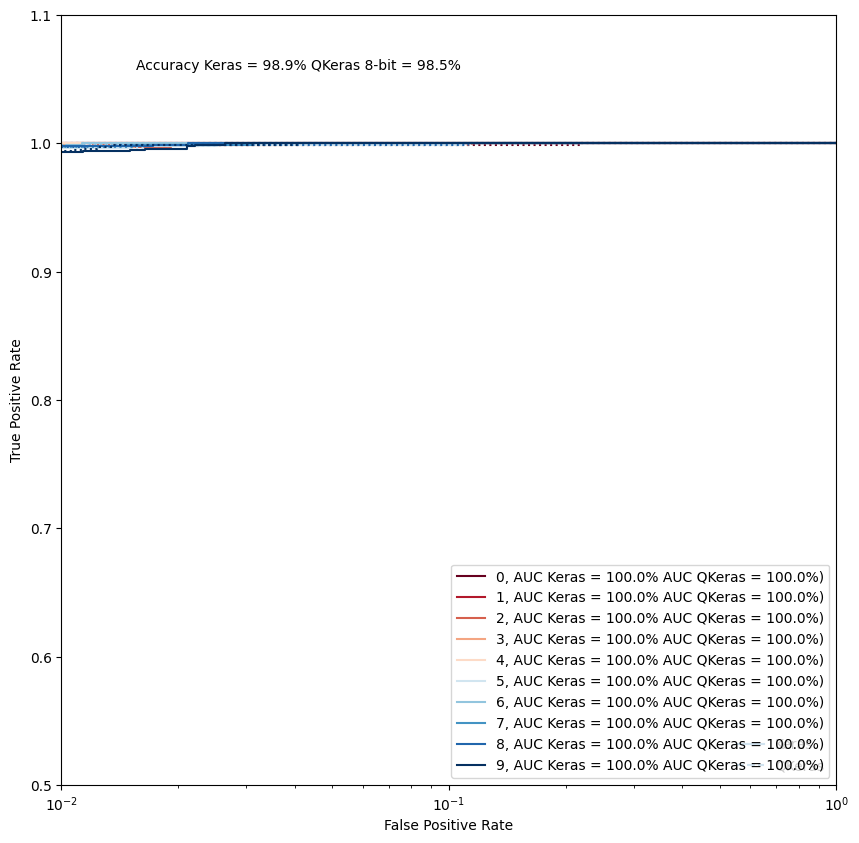

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics


labels = ['%i' % nr for nr in range(0, n_classes)]  # If you want to look at all the labels
# labels = ['0','1','9'] # Look at only a few labels, here for digits 0, 1 and 9
print('Plotting ROC for labels {}'.format(labels))

df = pd.DataFrame()
df_q = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}
fpr_q = {}
tpr_q = {}
auc1_q = {}
%matplotlib inline
colors = ['#67001f', '#b2182b', '#d6604d', '#f4a582', '#fddbc7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac', '#053061']
fig, ax = plt.subplots(figsize=(10, 10))
for i, label in enumerate(labels):
    df[label] = y_test[:, int(label)]
    df[label + '_pred'] = predict_baseline[:, int(label)]
    fpr[label], tpr[label], threshold = metrics.roc_curve(df[label], df[label + '_pred'])
    auc1[label] = metrics.auc(fpr[label], tpr[label])

    df_q[label] = y_test[:, int(label)]
    df_q[label + '_pred'] = predict_qkeras[:, int(label)]
    fpr_q[label], tpr_q[label], threshold_q = metrics.roc_curve(df_q[label], df_q[label + '_pred'])
    auc1_q[label] = metrics.auc(fpr_q[label], tpr_q[label])

    plt.plot(
        fpr[label],
        tpr[label],
        label=r'{}, AUC Keras = {:.1f}% AUC QKeras = {:.1f}%)'.format(label, auc1[label] * 100, auc1_q[label] * 100),
        linewidth=1.5,
        c=colors[i],
        linestyle='solid',
    )
    plt.plot(fpr_q[label], tpr_q[label], linewidth=1.5, c=colors[i], linestyle='dotted')

plt.semilogx()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.xlim(0.01, 1.0)
plt.ylim(0.5, 1.1)
plt.legend(loc='lower right')
plt.figtext(
    0.2,
    0.83,
    r'Accuracy Keras = {:.1f}% QKeras 8-bit = {:.1f}%'.format(test_score_baseline[1] * 100, test_score_qkeras[1] * 100),
    wrap=True,
    horizontalalignment='left',
    verticalalignment='center',
)
from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['Keras', 'QKeras'], loc='lower right', frameon=False)
ax.add_artist(leg)

Layer prune_low_magnitude_conv_0: % of zeros = 0.5
Layer bn_conv_0: % of zeros = 0.0
Layer prune_low_magnitude_conv_1: % of zeros = 0.5
Layer bn_conv_1: % of zeros = 0.0
Layer prune_low_magnitude_dense_0: % of zeros = 0.5
Layer bn_dense_0: % of zeros = 0.0
Layer output_dense: % of zeros = 0.0
Layer prune_low_magnitude_fused_convbn_0: % of zeros = 0.5
Layer prune_low_magnitude_fused_convbn_1: % of zeros = 0.5
Layer prune_low_magnitude_dense_0: % of zeros = 0.5
Layer bn_dense_0: % of zeros = 0.0
Layer output_dense: % of zeros = 0.0


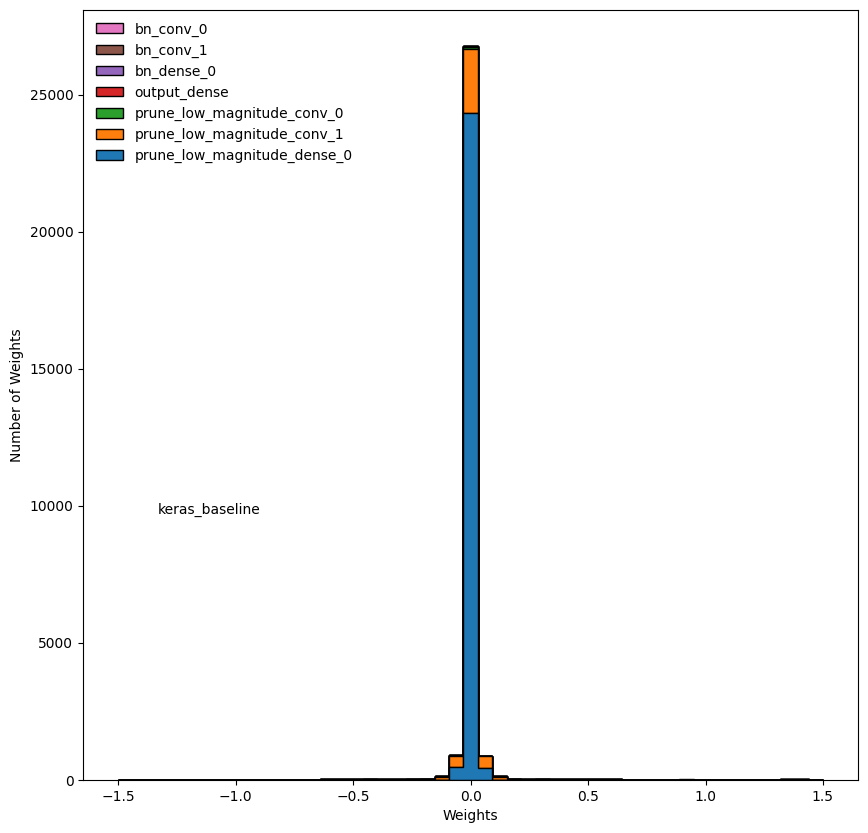

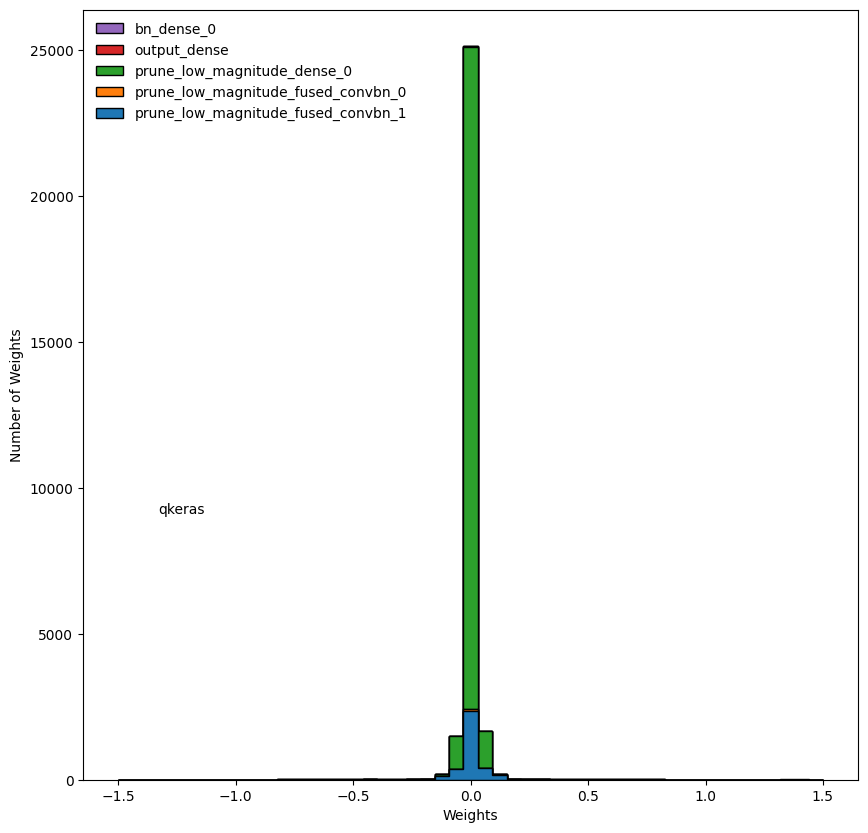

In [15]:
def doWeights(model):
    allWeightsByLayer = {}
    for layer in model.layers:
        if (layer._name).find("batch") != -1 or len(layer.get_weights()) < 1:
            continue
        weights = layer.weights[0].numpy().flatten()
        allWeightsByLayer[layer._name] = weights
        print('Layer {}: % of zeros = {}'.format(layer._name, np.sum(weights == 0) / np.size(weights)))

    labelsW = []
    histosW = []

    for key in reversed(sorted(allWeightsByLayer.keys())):
        labelsW.append(key)
        histosW.append(allWeightsByLayer[key])

    fig = plt.figure(figsize=(10, 10))
    bins = np.linspace(-1.5, 1.5, 50)
    plt.hist(histosW, bins, histtype='stepfilled', stacked=True, label=labelsW, edgecolor='black')
    plt.legend(frameon=False, loc='upper left')
    plt.ylabel('Number of Weights')
    plt.xlabel('Weights')
    plt.figtext(0.2, 0.38, model._name, wrap=True, horizontalalignment='left', verticalalignment='center')


doWeights(model_pruned)
doWeights(qmodel_pruned)

In [16]:
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

from qkeras.utils import _add_supported_quantized_objects

co = {}
_add_supported_quantized_objects(co)
co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude

model = tf.keras.models.load_model(save_path, custom_objects=co)
model = strip_pruning(model)

qmodel = tf.keras.models.load_model(q_save_path, custom_objects=co)
qmodel = strip_pruning(qmodel)

In [17]:
project_folder = 'Projects'

In [18]:
import hls4ml
import utils.plotting as plotting

# Auto-generate base config
hls_config = hls4ml.utils.config_from_keras_model(
    model,
    granularity='name',
    backend='Vitis',
    default_precision='ap_fixed<16,6>'
)

# Custom performance overrides
for layer_name, layer_cfg in hls_config['LayerName'].items():
    layer_cfg['Strategy'] = 'Latency'
    layer_cfg['ReuseFactor'] = 32
    if 'FifoDepth' not in layer_cfg:
        layer_cfg['FifoDepth'] = 4

plotting.print_dict(hls_config)

save_proj_path = os.path.join(project_folder, 'Baseline')

# Convert and compile
hls_model = hls4ml.converters.convert_from_keras_model(
    model,
    hls_config=hls_config,
    backend='Vitis',
    output_dir=save_proj_path,
    part='xczu5ev-sfvc784-1-i',
    io_type='io_stream',
    clock_period=5,
    trace=True,
    output_format='vhdl',  # <- Force VHDL output
    generate_hls_ip=True  # <--- ADD THIS
)
hls_model.compile()


Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 28, 28, 1]], output shape: [None, 28, 28, 1]
Layer name: conv_0, layer type: Conv2D, input shapes: [[None, 28, 28, 1]], output shape: [None, 26, 26, 16]
Layer name: bn_conv_0, layer type: BatchNormalization, input shapes: [[None, 26, 26, 16]], output shape: [None, 26, 26, 16]
Layer name: conv_act_0, layer type: Activation, input shapes: [[None, 26, 26, 16]], output shape: [None, 26, 26, 16]
Layer name: pool_0, layer type: MaxPooling2D, input shapes: [[None, 26, 26, 16]], output shape: [None, 13, 13, 16]
Layer name: conv_1, layer type: Conv2D, input shapes: [[None, 13, 13, 16]], output shape: [None, 11, 11, 24]
Layer name: bn_conv_1, layer type: BatchNormalization, input shapes: [[None, 11, 11, 24]], output shape: [None, 11, 11, 24]
Layer name: conv_act_1, layer type: Activation, input shapes: [[None, 11, 11, 24]], output shape: [None, 11, 11, 24]
Layer name: pool_1, layer type: MaxPooling2D,

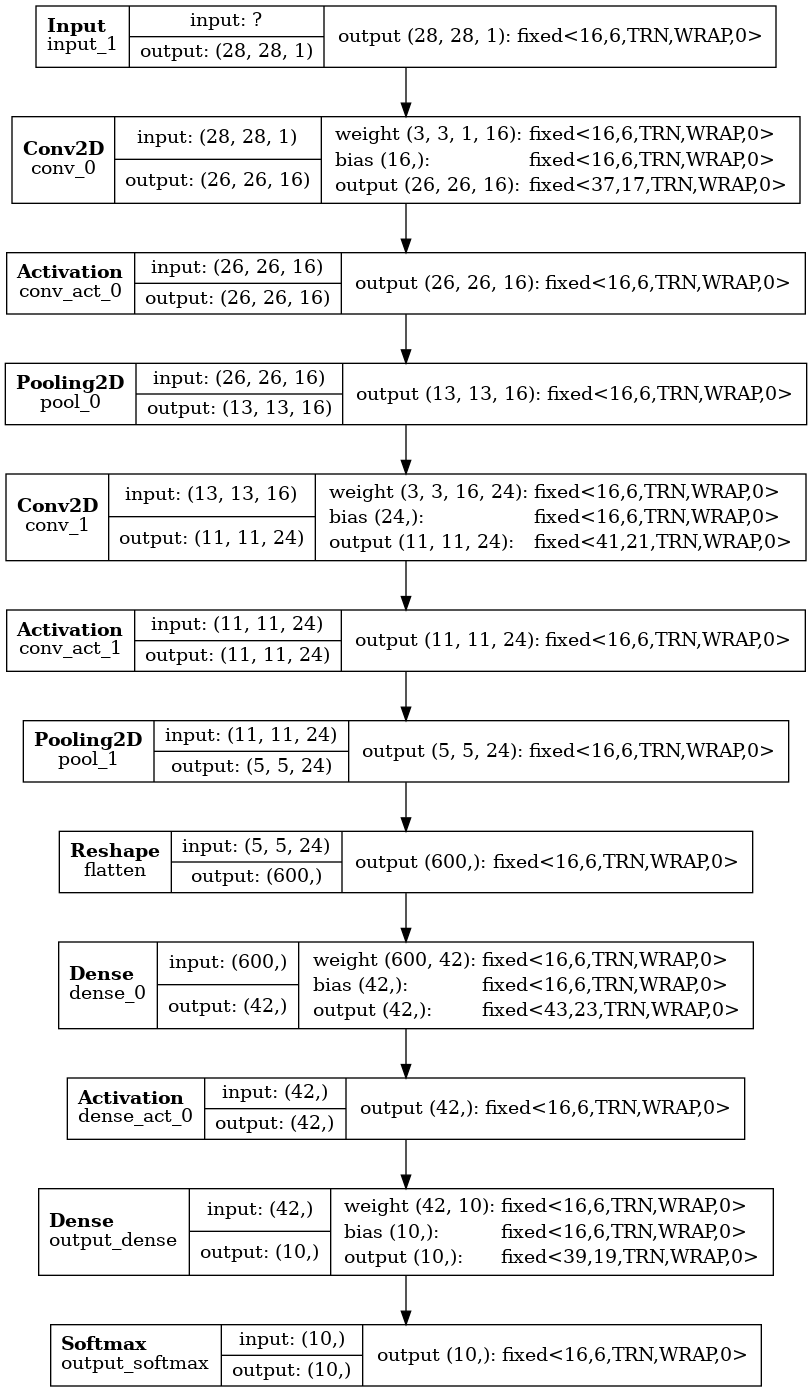

In [19]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 28, 28, 1]], output shape: [None, 28, 28, 1]
Layer name: conv_0, layer type: Conv2D, input shapes: [[None, 28, 28, 1]], output shape: [None, 26, 26, 16]
Layer name: bn_conv_0, layer type: BatchNormalization, input shapes: [[None, 26, 26, 16]], output shape: [None, 26, 26, 16]
Layer name: conv_act_0, layer type: Activation, input shapes: [[None, 26, 26, 16]], output shape: [None, 26, 26, 16]
Layer name: pool_0, layer type: MaxPooling2D, input shapes: [[None, 26, 26, 16]], output shape: [None, 13, 13, 16]
Layer name: conv_1, layer type: Conv2D, input shapes: [[None, 13, 13, 16]], output shape: [None, 11, 11, 24]
Layer name: bn_conv_1, layer type: BatchNormalization, input shapes: [[None, 11, 11, 24]], output shape: [None, 11, 11, 24]
Layer name: conv_act_1, layer type: Activation, input shapes: [[None, 11, 11, 24]], output shape: [None, 11, 11, 24]
Layer name: pool_1, layer type: MaxPooling2D,

(<Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>,
 None,
 None)

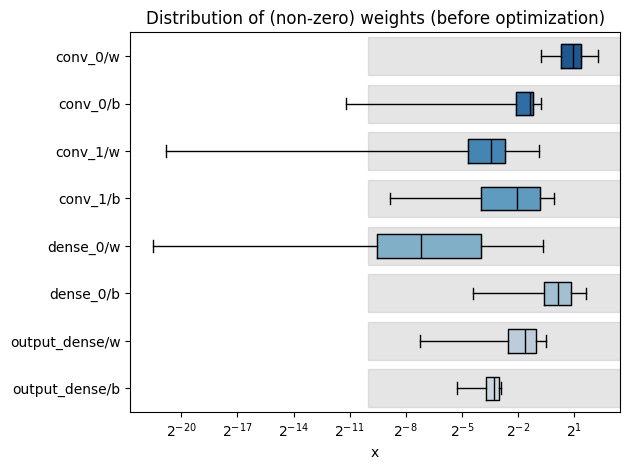

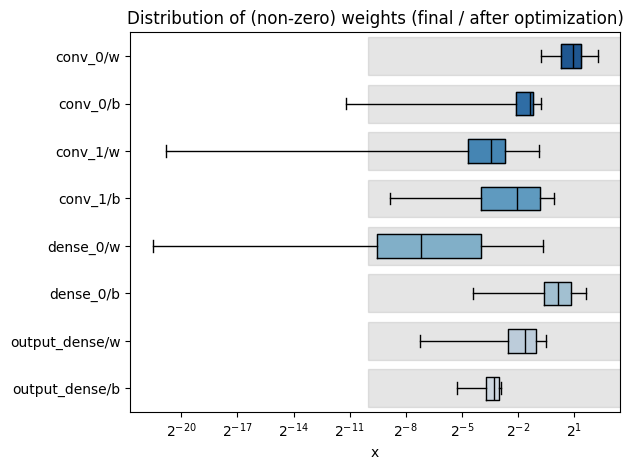

In [20]:
from hls4ml.model.profiling import numerical

numerical(model=model, hls_model=hls_model)

In [24]:

# Generate config from QKeras model
hls_config_q = hls4ml.utils.config_from_keras_model(
    qmodel,
    granularity='name',
    backend='Vitis',
)

# Inject optimizations
hls_config_q['Model']['Precision'] = 'ap_fixed<16,6>'
hls_config_q['Model']['PruneReuseFactorStrategy'] = 'load_balance'

for lname, lcfg in hls_config_q['LayerName'].items():
    lcfg['Strategy'] = 'Latency'
    lcfg['ReuseFactor'] = 32

plotting.print_dict(hls_config_q)

save_proj_path = os.path.join(project_folder, 'Quantized')

# Convert and compile
hls_model_q = hls4ml.converters.convert_from_keras_model(
    qmodel,
    hls_config=hls_config_q,
    output_dir=save_proj_path,
    backend='Vitis',
    io_type='io_stream',
    clock_period=5,
    trace=True,
    part = 'xczu5ev-sfvc784-1-i',
    output_format='vhdl',  # <- Force VHDL output
    generate_hls_ip=True  # <--- ADD THIS
)

hls_model_q.compile()


/home/theodoros/Documents/AI_ON_FPGA/.venv/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


Interpreting Model
Topology:
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 28, 28, 1]], output shape: [None, 28, 28, 1]
Layer name: fused_convbn_0, layer type: QConv2DBatchnorm, input shapes: [[None, 28, 28, 1]], output shape: [None, 26, 26, 16]
Layer name: conv_act_0, layer type: Activation, input shapes: [[None, 26, 26, 16]], output shape: [None, 26, 26, 16]
Layer name: pool_0, layer type: MaxPooling2D, input shapes: [[None, 26, 26, 16]], output shape: [None, 13, 13, 16]
Layer name: fused_convbn_1, layer type: QConv2DBatchnorm, input shapes: [[None, 13, 13, 16]], output shape: [None, 11, 11, 24]
Layer name: conv_act_1, layer type: Activation, input shapes: [[None, 11, 11, 24]], output shape: [None, 11, 11, 24]
Layer name: pool_1, layer type: MaxPooling2D, input shapes: [[None, 11, 11, 24]], output shape: [None, 5, 5, 24]
Layer name: flatten_1, layer type: Reshape, input shapes: [[None, 5, 5, 24]], output shape: [None, 600]
Layer name: dense_0, layer type: QDense,

Interpreting Model
Topology:
Layer name: input_2, layer type: InputLayer, input shapes: [[None, 28, 28, 1]], output shape: [None, 28, 28, 1]
Layer name: fused_convbn_0, layer type: QConv2DBatchnorm, input shapes: [[None, 28, 28, 1]], output shape: [None, 26, 26, 16]
Layer name: conv_act_0, layer type: Activation, input shapes: [[None, 26, 26, 16]], output shape: [None, 26, 26, 16]
Layer name: pool_0, layer type: MaxPooling2D, input shapes: [[None, 26, 26, 16]], output shape: [None, 13, 13, 16]
Layer name: fused_convbn_1, layer type: QConv2DBatchnorm, input shapes: [[None, 13, 13, 16]], output shape: [None, 11, 11, 24]
Layer name: conv_act_1, layer type: Activation, input shapes: [[None, 11, 11, 24]], output shape: [None, 11, 11, 24]
Layer name: pool_1, layer type: MaxPooling2D, input shapes: [[None, 11, 11, 24]], output shape: [None, 5, 5, 24]
Layer name: flatten_1, layer type: Reshape, input shapes: [[None, 5, 5, 24]], output shape: [None, 600]
Layer name: dense_0, layer type: QDense,

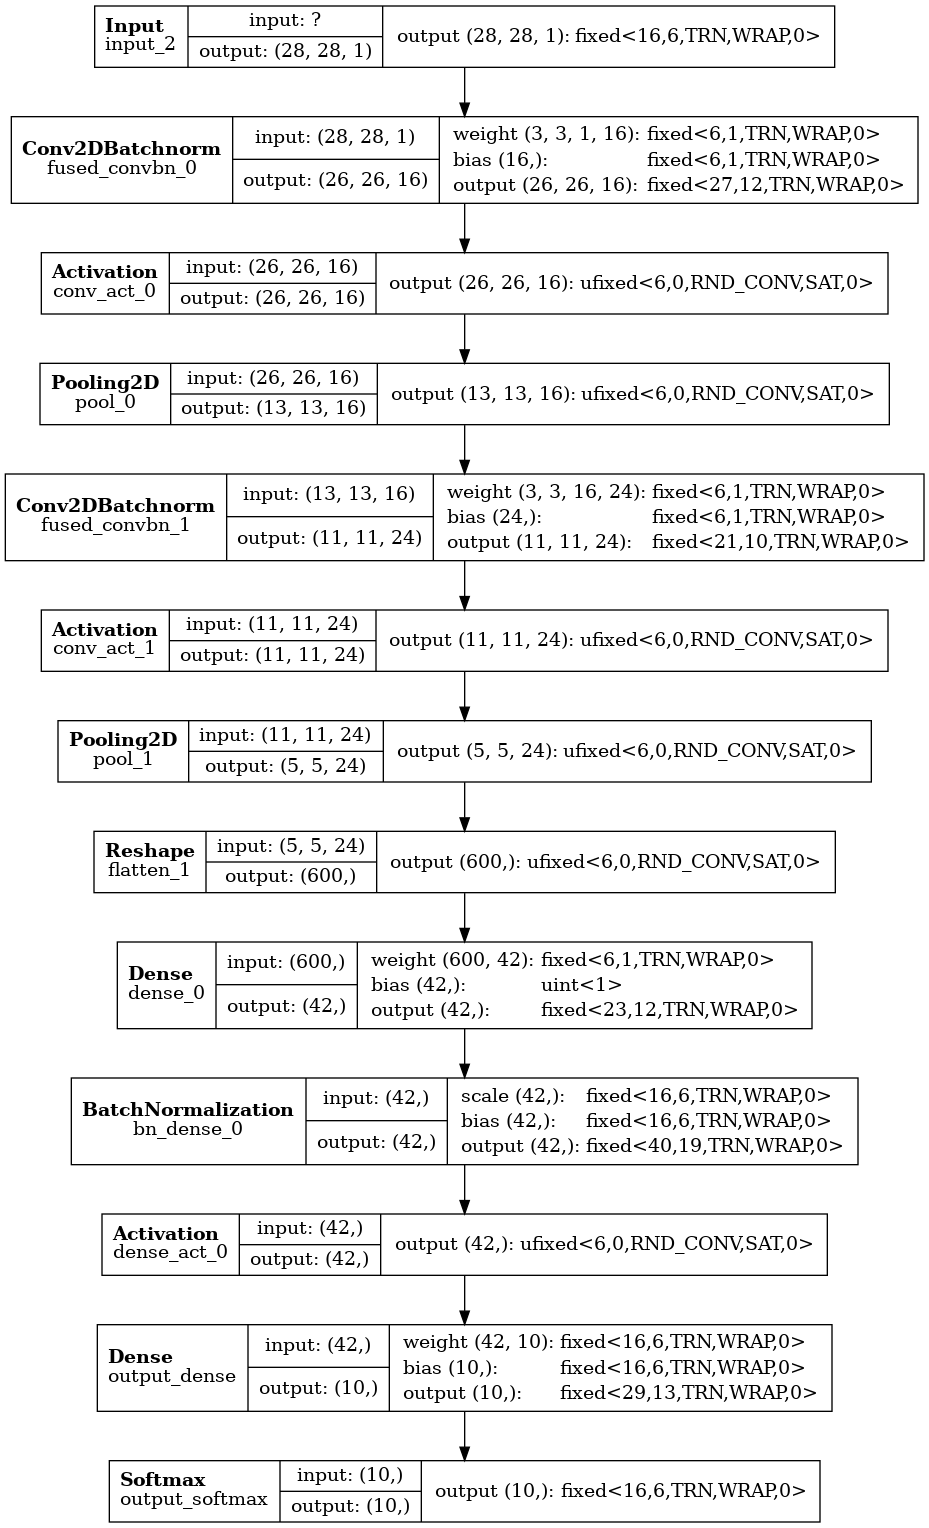

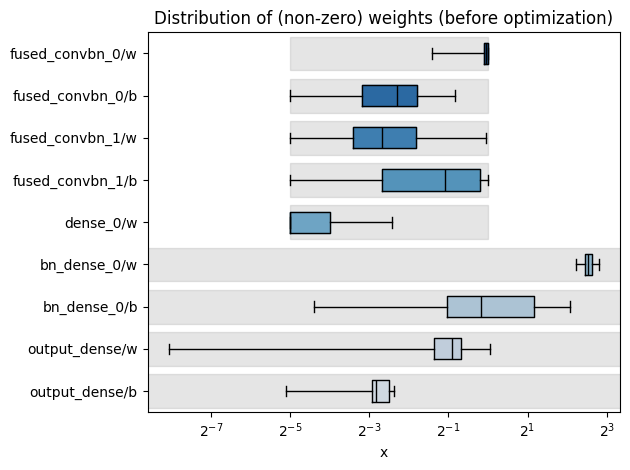

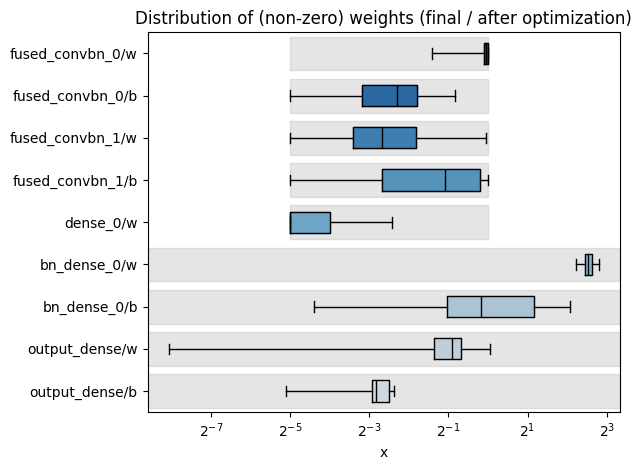

In [25]:
numerical(model=qmodel, hls_model=hls_model_q)
hls4ml.utils.plot_model(hls_model_q, show_shapes=True, show_precision=True, to_file=None)

In [26]:
y_predict = model.predict(x_test)
y_predict_hls4ml = hls_model.predict(np.ascontiguousarray(x_test))

313/313 [==============================] - 0s 664us/step


In [27]:
y_predict_q = qmodel.predict(x_test)
y_predict_hls4ml_q = hls_model_q.predict(np.ascontiguousarray(x_test))

313/313 [==============================] - 1s 2ms/step


Accuracy Keras:  0.9894
Accuracy hls4ml: 0.9887
Accuracy Keras:  0.9852
Accuracy hls4ml: 0.985


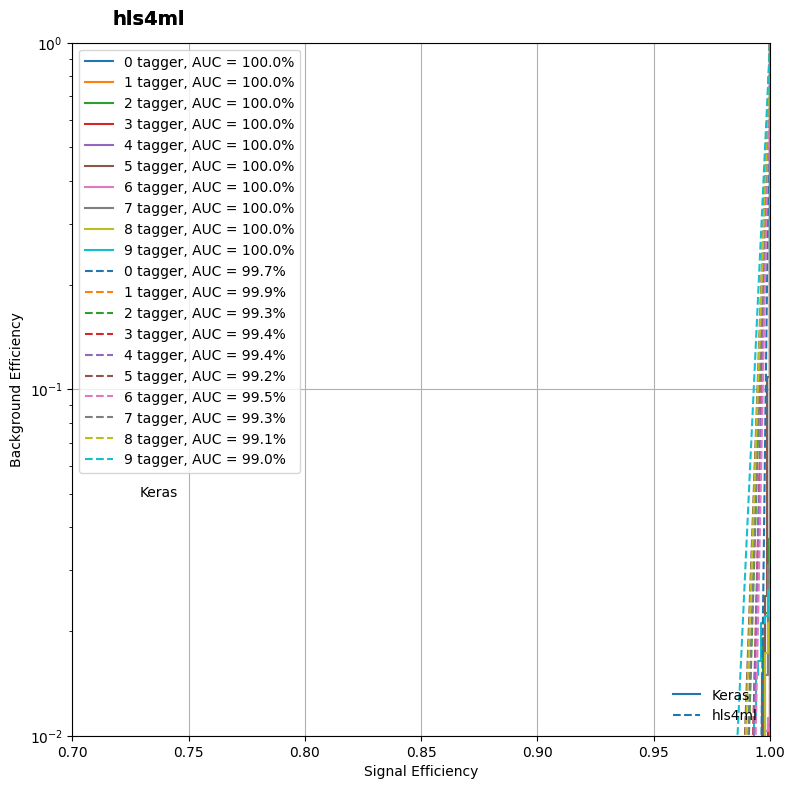

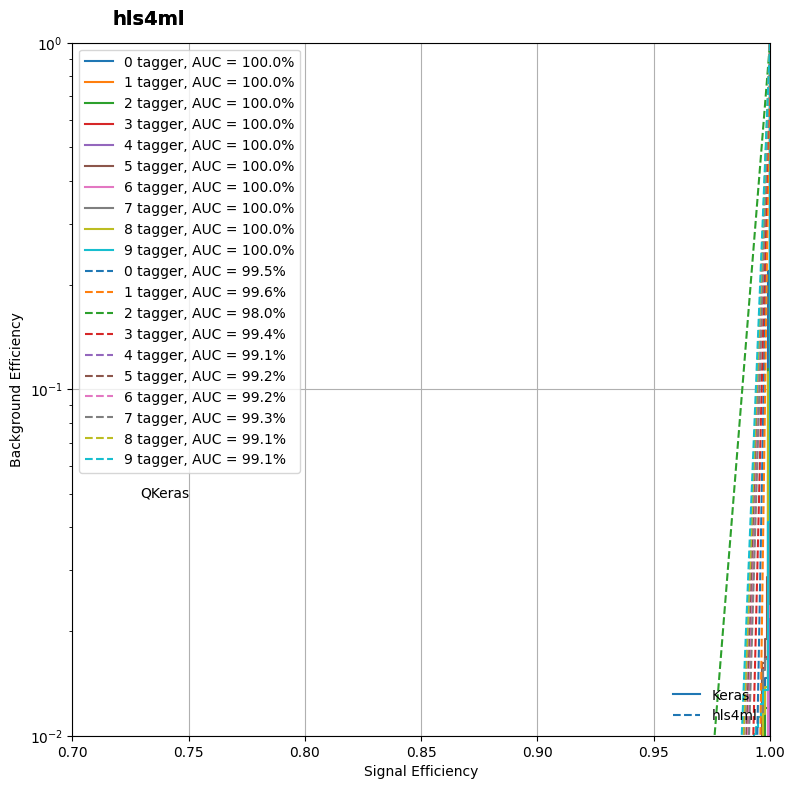

In [28]:
import utils.plotting as plotting
from sklearn.metrics import accuracy_score


def plotROC(Y, y_pred, y_pred_hls4ml, label="Model"):
    accuracy_keras = float(accuracy_score(np.argmax(Y, axis=1), np.argmax(y_pred, axis=1)))
    accuracy_hls4ml = float(accuracy_score(np.argmax(Y, axis=1), np.argmax(y_pred_hls4ml, axis=1)))

    print("Accuracy Keras:  {}".format(accuracy_keras))
    print("Accuracy hls4ml: {}".format(accuracy_hls4ml))

    fig, ax = plt.subplots(figsize=(9, 9))
    _ = plotting.makeRoc(Y, y_pred, labels=['%i' % nr for nr in range(n_classes)])
    plt.gca().set_prop_cycle(None)  # reset the colors
    _ = plotting.makeRoc(Y, y_pred_hls4ml, labels=['%i' % nr for nr in range(n_classes)], linestyle='--')

    from matplotlib.lines import Line2D

    lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
    from matplotlib.legend import Legend

    leg = Legend(ax, lines, labels=['Keras', 'hls4ml'], loc='lower right', frameon=False)
    ax.add_artist(leg)
    plt.figtext(0.2, 0.38, label, wrap=True, horizontalalignment='left', verticalalignment='center')
    plt.ylim(0.01, 1.0)
    plt.xlim(0.7, 1.0)


# Plot the pruned floating point model:
plotROC(y_test, y_predict, y_predict_hls4ml, label="Keras")

# Plot the pruned and quantized QKeras model
plotROC(y_test, y_predict_q, y_predict_hls4ml_q, label="QKeras")

In [ ]:
synth = True  # Only if you want to synthesize the models yourself (>1h per model) rather than look at the provided reports.
if synth:
    hls_model.build(csim=False, synth=True, vsynth=False, export=True)
    

Writing HLS project
Done

****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2024.2 (64-bit)
  **** SW Build 5238294 on Nov  8 2024
  **** IP Build 5239520 on Sun Nov 10 16:12:51 MST 2024
  **** SharedData Build 5239561 on Fri Nov 08 14:39:27 MST 2024
  **** Start of session at: Wed Apr  9 14:09:15 2025
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
    ** Copyright 2022-2024 Advanced Micro Devices, Inc. All Rights Reserved.

source /tools/Xilinx/Vitis/2024.2/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] For user 'theodoros' on host 'theodoros-MS-7D75' (Linux_x86_64 version 6.8.0-57-generic) on Wed Apr 09 14:09:17 EEST 2025
INFO: [HLS 200-10] On os Ubuntu 22.04.5 LTS
INFO: [HLS 200-10] In directory '/home/theodoros/Documents/AI_ON_FPGA/Projects/Baseline'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project myproject_prj 
INFO: [HLS 200-10] Creating and opening project '/home/theodoros/Documents/AI_ON_FPGA/Projects/Baseline/my

In [ ]:
synth = True  # Only if you want to synthesize the models yourself (>1h per model) rather than look at the provided reports.
if synth:
    hls_model_q.build(csim=False, synth=True, vsynth=False, export=True)